In [18]:
from sympy import *
from sympy.matrices import BlockMatrix, Matrix, zeros
import sympy as sp
import numpy as np

In [19]:
Ts = 0.04
dt = 0.01
foot_height_keep_STF = 0.2
N = int(Ts/dt)
print('Nb steps = ', N)
nb_total_variables_per_coordinate = int(3 * N) # px, vx, zx
print('nb_total_variables_per_coordinate', nb_total_variables_per_coordinate)
nb_total_variables = 3 * nb_total_variables_per_coordinate # x, y, z
print(nb_total_variables, 'variables')

Nb steps =  4
nb_total_variables_per_coordinate 12
36 variables


In [20]:
variables = []
coord = ['x', 'y', 'z']
for c in coord:
    for i in range(N):
        p = symbols(f'p{c}{i}')
        v = symbols(f'v{c}{i}')
        a = symbols(f'a{c}{i}')
        variables.extend([p, v, a])
pva_vector = Matrix(variables)
print('------------------- Optimization Variable -------------------')
print('pva_vector = ', len(pva_vector), ' variables')
for i in range(3):
    pprint(pva_vector.T[i*nb_total_variables_per_coordinate:(i+1)*nb_total_variables_per_coordinate])


------------------- Optimization Variable -------------------
pva_vector =  36  variables
[px₀, vx₀, ax₀, px₁, vx₁, ax₁, px₂, vx₂, ax₂, px₃, vx₃, ax₃]
[py₀, vy₀, ay₀, py₁, vy₁, ay₁, py₂, vy₂, ay₂, py₃, vy₃, ay₃]
[pz₀, vz₀, az₀, pz₁, vz₁, az₁, pz₂, vz₂, az₂, pz₃, vz₃, az₃]


In [21]:
print('------------------- P Mat -------------------')
opt_weight_desired_pos = 10
opt_weight_desired_vel = 1
zero_matrix_3_by_3 = Matrix([[0, 0, 0], [0, 0, 0], [0, 0, 0]])

p_N_des = sp.Matrix([0.2, 0.3, 0.1])
v_N_des = sp.zeros(3)

q = zeros(nb_total_variables, 1)
P_matrix = zeros(nb_total_variables, nb_total_variables)

for i in range(nb_total_variables_per_coordinate):
    P_matrix[i * 3 + 2, i * 3 + 2] = 1.0

for i in range(3):
    P_matrix[(i + 1) * nb_total_variables_per_coordinate - 3, (i + 1) * nb_total_variables_per_coordinate - 3] = opt_weight_desired_pos
    P_matrix[(i + 1) * nb_total_variables_per_coordinate - 2, (i + 1) * nb_total_variables_per_coordinate - 2] = opt_weight_desired_vel

    q[(i+1) * nb_total_variables_per_coordinate - 3] = -2 * opt_weight_desired_pos * p_N_des[i]
    q[(i+1) * nb_total_variables_per_coordinate - 2] = -2 * opt_weight_desired_vel * v_N_des[i]

vPv = pva_vector.T * P_matrix * pva_vector

objective_function = vPv + q.T * pva_vector
print('Objective function')
pprint(objective_function)


------------------- P Mat -------------------
Objective function
⎡       2          2          2          2          2          2          2   
⎣1.0⋅ax₀  + 1.0⋅ax₁  + 1.0⋅ax₂  + 1.0⋅ax₃  + 1.0⋅ay₀  + 1.0⋅ay₁  + 1.0⋅ay₂  + 

       2          2          2          2          2         2                
1.0⋅ay₃  + 1.0⋅az₀  + 1.0⋅az₁  + 1.0⋅az₂  + 1.0⋅az₃  + 10⋅px₃  - 4.0⋅px₃ + 10⋅

   2                   2                2      2      2⎤
py₃  - 6.0⋅py₃ + 10⋅pz₃  - 2.0⋅pz₃ + vx₃  + vy₃  + vz₃ ⎦


In [22]:

A_eq_pos_vel_des = sp.zeros(6, nb_total_variables)

A_eq_pos_vel_des[0, 0] = 1
A_eq_pos_vel_des[1, 1] = 1

A_eq_pos_vel_des[2, nb_total_variables_per_coordinate] = 1
A_eq_pos_vel_des[3, nb_total_variables_per_coordinate + 1] = 1

A_eq_pos_vel_des[4, 2*nb_total_variables_per_coordinate] = 1
A_eq_pos_vel_des[5, 2*nb_total_variables_per_coordinate + 1] = 1

result_vector = A_eq_pos_vel_des*pva_vector
print('------------------- Boundary Points Equality Contraints -------------------')
print('A_eq_pos_vel_desired * v = ')
pprint(result_vector)

------------------- Boundary Points Equality Contraints -------------------
A_eq_pos_vel_desired * v = 
⎡px₀⎤
⎢   ⎥
⎢vx₀⎥
⎢   ⎥
⎢py₀⎥
⎢   ⎥
⎢vy₀⎥
⎢   ⎥
⎢pz₀⎥
⎢   ⎥
⎣vz₀⎦


In [23]:
dt_symbol = symbols('dt')
block_dynamics = zeros(2, 6)
block_dynamics[0, 0] = 1
block_dynamics[0, 1] = dt_symbol
block_dynamics[0, 3] = -1
block_dynamics[1, 1] = 1
block_dynamics[1, 2] = dt_symbol
block_dynamics[1, 4] = -1
A_dynamics_per_coordinate = zeros(2 * N - 2, 3 * N)

j = 0
for i in range(int((2 * N - 2)/2)):
    A_dynamics_per_coordinate[j : j + 2, i * 3: i * 3 + 6] = block_dynamics
    j = j + 2

pva_vector_x_comp = pva_vector[0:nb_total_variables_per_coordinate, 0]

size_rows_A = A_dynamics_per_coordinate.shape[0]
size_cols_A = A_dynamics_per_coordinate.shape[1]
A_dynamics = zeros(3 * size_rows_A, nb_total_variables)

for i in range(3):
    A_dynamics[i * size_rows_A : i * size_rows_A + size_rows_A, i * size_cols_A : i * size_cols_A + size_cols_A] = A_dynamics_per_coordinate

mult = A_dynamics * pva_vector
print('------------------- Dynamic Contraints -------------------')
pprint(mult)

------------------- Dynamic Contraints -------------------
⎡dt⋅vx₀ + px₀ - px₁⎤
⎢                  ⎥
⎢ax₀⋅dt + vx₀ - vx₁⎥
⎢                  ⎥
⎢dt⋅vx₁ + px₁ - px₂⎥
⎢                  ⎥
⎢ax₁⋅dt + vx₁ - vx₂⎥
⎢                  ⎥
⎢dt⋅vx₂ + px₂ - px₃⎥
⎢                  ⎥
⎢ax₂⋅dt + vx₂ - vx₃⎥
⎢                  ⎥
⎢dt⋅vy₀ + py₀ - py₁⎥
⎢                  ⎥
⎢ay₀⋅dt + vy₀ - vy₁⎥
⎢                  ⎥
⎢dt⋅vy₁ + py₁ - py₂⎥
⎢                  ⎥
⎢ay₁⋅dt + vy₁ - vy₂⎥
⎢                  ⎥
⎢dt⋅vy₂ + py₂ - py₃⎥
⎢                  ⎥
⎢ay₂⋅dt + vy₂ - vy₃⎥
⎢                  ⎥
⎢dt⋅vz₀ + pz₀ - pz₁⎥
⎢                  ⎥
⎢az₀⋅dt + vz₀ - vz₁⎥
⎢                  ⎥
⎢dt⋅vz₁ + pz₁ - pz₂⎥
⎢                  ⎥
⎢az₁⋅dt + vz₁ - vz₂⎥
⎢                  ⎥
⎢dt⋅vz₂ + pz₂ - pz₃⎥
⎢                  ⎥
⎣az₂⋅dt + vz₂ - vz₃⎦


In [24]:
block = zeros(2, 3)
block[0, 1] = 1
block[1, 2] = 1
A_limits = zeros(nb_total_variables_per_coordinate * 2, nb_total_variables)

for i in range(nb_total_variables_per_coordinate):
    A_limits[2*i:2*(i+1), 3*i:3*(i+1)] = block

pprint((A_limits*pva_vector).T)

[vx₀  ax₀  vx₁  ax₁  vx₂  ax₂  vx₃  ax₃  vy₀  ay₀  vy₁  ay₁  vy₂  ay₂  vy₃  ay
₃  vz₀  az₀  vz₁  az₁  vz₂  az₂  vz₃  az₃]


In [25]:
A_total = Matrix.vstack(A_eq_pos_vel_des,
                    A_dynamics,
                    A_limits)

print('A * PVA_VECTOR')
pprint(A_total*pva_vector)

A * PVA_VECTOR
⎡       px₀        ⎤
⎢                  ⎥
⎢       vx₀        ⎥
⎢                  ⎥
⎢       py₀        ⎥
⎢                  ⎥
⎢       vy₀        ⎥
⎢                  ⎥
⎢       pz₀        ⎥
⎢                  ⎥
⎢       vz₀        ⎥
⎢                  ⎥
⎢dt⋅vx₀ + px₀ - px₁⎥
⎢                  ⎥
⎢ax₀⋅dt + vx₀ - vx₁⎥
⎢                  ⎥
⎢dt⋅vx₁ + px₁ - px₂⎥
⎢                  ⎥
⎢ax₁⋅dt + vx₁ - vx₂⎥
⎢                  ⎥
⎢dt⋅vx₂ + px₂ - px₃⎥
⎢                  ⎥
⎢ax₂⋅dt + vx₂ - vx₃⎥
⎢                  ⎥
⎢dt⋅vy₀ + py₀ - py₁⎥
⎢                  ⎥
⎢ay₀⋅dt + vy₀ - vy₁⎥
⎢                  ⎥
⎢dt⋅vy₁ + py₁ - py₂⎥
⎢                  ⎥
⎢ay₁⋅dt + vy₁ - vy₂⎥
⎢                  ⎥
⎢dt⋅vy₂ + py₂ - py₃⎥
⎢                  ⎥
⎢ay₂⋅dt + vy₂ - vy₃⎥
⎢                  ⎥
⎢dt⋅vz₀ + pz₀ - pz₁⎥
⎢                  ⎥
⎢az₀⋅dt + vz₀ - vz₁⎥
⎢                  ⎥
⎢dt⋅vz₁ + pz₁ - pz₂⎥
⎢                  ⎥
⎢az₁⋅dt + vz₁ - vz₂⎥
⎢                  ⎥
⎢dt⋅vz₂ + pz₂ - pz₃⎥
⎢                  ⎥
⎢az₂⋅dt + vz₂ - vz₃

In [26]:
# Limits
p0_desired = 0.0
v0_desired = 0.0

l_boundary_pts_per_coordinate = Matrix([p0_desired, v0_desired])
u_boundary_pts_per_coordinate = Matrix([p0_desired, v0_desired])


l_boundary_pts = Matrix.vstack(l_boundary_pts_per_coordinate, l_boundary_pts_per_coordinate, l_boundary_pts_per_coordinate)
u_boundary_pts = Matrix.vstack(u_boundary_pts_per_coordinate, u_boundary_pts_per_coordinate, u_boundary_pts_per_coordinate)

l_boundary_pts

Matrix([
[0],
[0],
[0],
[0],
[0],
[0]])

In [27]:
v_max = 20.0
a_max = 100.0
l_limits_per_coordinate = zeros(2 * N, 1)
u_limits_per_coordinate = zeros(2 * N, 1)

for i in range(0, 2 * N, 2):
    l_limits_per_coordinate[i, 0] = -v_max
    u_limits_per_coordinate[i, 0] = v_max

for i in range(1, 2 * N, 2):
    l_limits_per_coordinate[i, 0] = -a_max
    u_limits_per_coordinate[i, 0] = a_max


l_limits = Matrix.vstack(l_limits_per_coordinate, l_limits_per_coordinate, l_limits_per_coordinate)
u_limits = Matrix.vstack(u_limits_per_coordinate, u_limits_per_coordinate, u_limits_per_coordinate)
pprint(l_limits.T)
pprint(u_limits.T)


[-20.0  -100.0  -20.0  -100.0  -20.0  -100.0  -20.0  -100.0  -20.0  -100.0  -2
0.0  -100.0  -20.0  -100.0  -20.0  -100.0  -20.0  -100.0  -20.0  -100.0  -20.0
  -100.0  -20.0  -100.0]
[20.0  100.0  20.0  100.0  20.0  100.0  20.0  100.0  20.0  100.0  20.0  100.0 
 20.0  100.0  20.0  100.0  20.0  100.0  20.0  100.0  20.0  100.0  20.0  100.0]


In [28]:

T_keep = 33/100*Ts
T_start_keep = 33/100*Ts
T_end_keep = T_keep + T_start_keep
n_keep = int(T_keep/dt)
n_start_keep = int(T_start_keep/dt)
n_end_keep = n_keep + n_start_keep

A_keep_foot = zeros(n_keep, nb_total_variables)

j = n_start_keep
for i in range(n_keep):
    A_keep_foot[i, 2*nb_total_variables_per_coordinate + 3*j] = 1
    j = j + 1

pprint(A_keep_foot @ pva_vector)

[pz₁]


In [29]:
pprint(pva_vector[0])
pprint(pva_vector[nb_total_variables_per_coordinate-3])

pprint(pva_vector[0:nb_total_variables_per_coordinate:3])

px₀
px₃
[px₀, px₁, px₂, px₃]


In [30]:
import pandas as pd

df_list = []
for i in range(29):
    df = pd.read_csv('output_foot_traj_cpp_' + str(i) + '.csv')
    df_list.append(df)


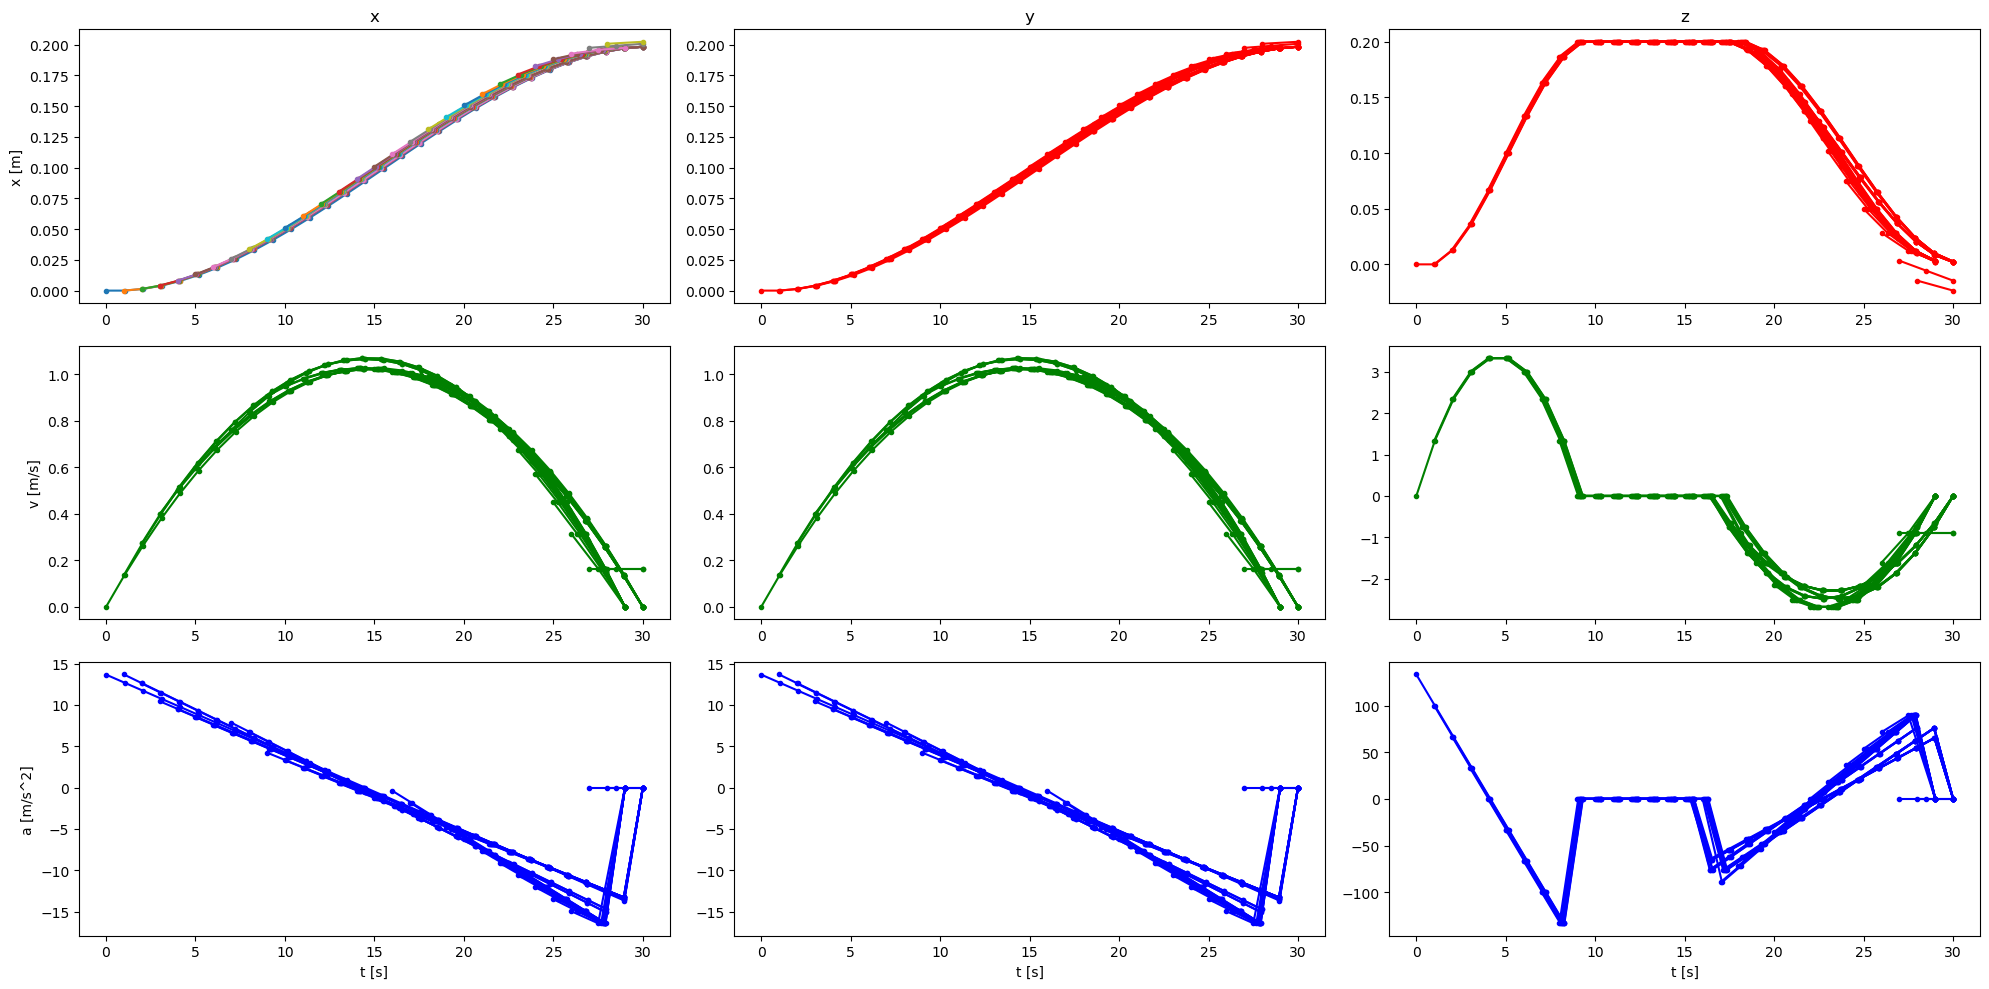

In [31]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3, figsize=(20, 10))

for idx, df in enumerate(df_list):
    t = np.linspace(idx, len(df['Position_X']) + idx, len(df['Position_X']))

    axs[0, 0].set_title('x')
    axs[0, 0].plot(t, df['Position_X'], '.-', label='pos')
    axs[0, 0].set_ylabel('x [m]')
    
    axs[1, 0].plot(t, df['Velocity_X'], '.-g', label='vel')
    axs[1, 0].set_ylabel('v [m/s]')

    # axs[1].plot(t[-1], v_N_desired, 'o')
    axs[2, 0].plot(t, df['Acceleration_X'], '.-b', label='acc')
    axs[2, 0].set_ylabel('a [m/s^2]')
    axs[2, 0].set_xlabel('t [s]')

    axs[0, 1].set_title('y')
    axs[0, 1].plot(t, df['Position_Y'], '.-r', label='pos')
    axs[1, 1].plot(t, df['Velocity_Y'], '.-g', label='vel')
    # axs[1].plot(t[-1], v_N_desired, 'o')
    axs[2, 1].plot(t, df['Acceleration_Y'], '.-b', label='acc')
    axs[2, 1].set_xlabel('t [s]')

    axs[0, 2].set_title('z')
    axs[0, 2].plot(t, df['Position_Z'], '.-r', label='pos')
    axs[1, 2].plot(t, df['Velocity_Z'], '.-g', label='vel')
    axs[2, 2].plot(t, df['Acceleration_Z'], '.-b', label='acc')
    axs[2, 2].set_xlabel('t [s]')

    plt.tight_layout()
    # [a.legend() for a in axs]
plt.show()

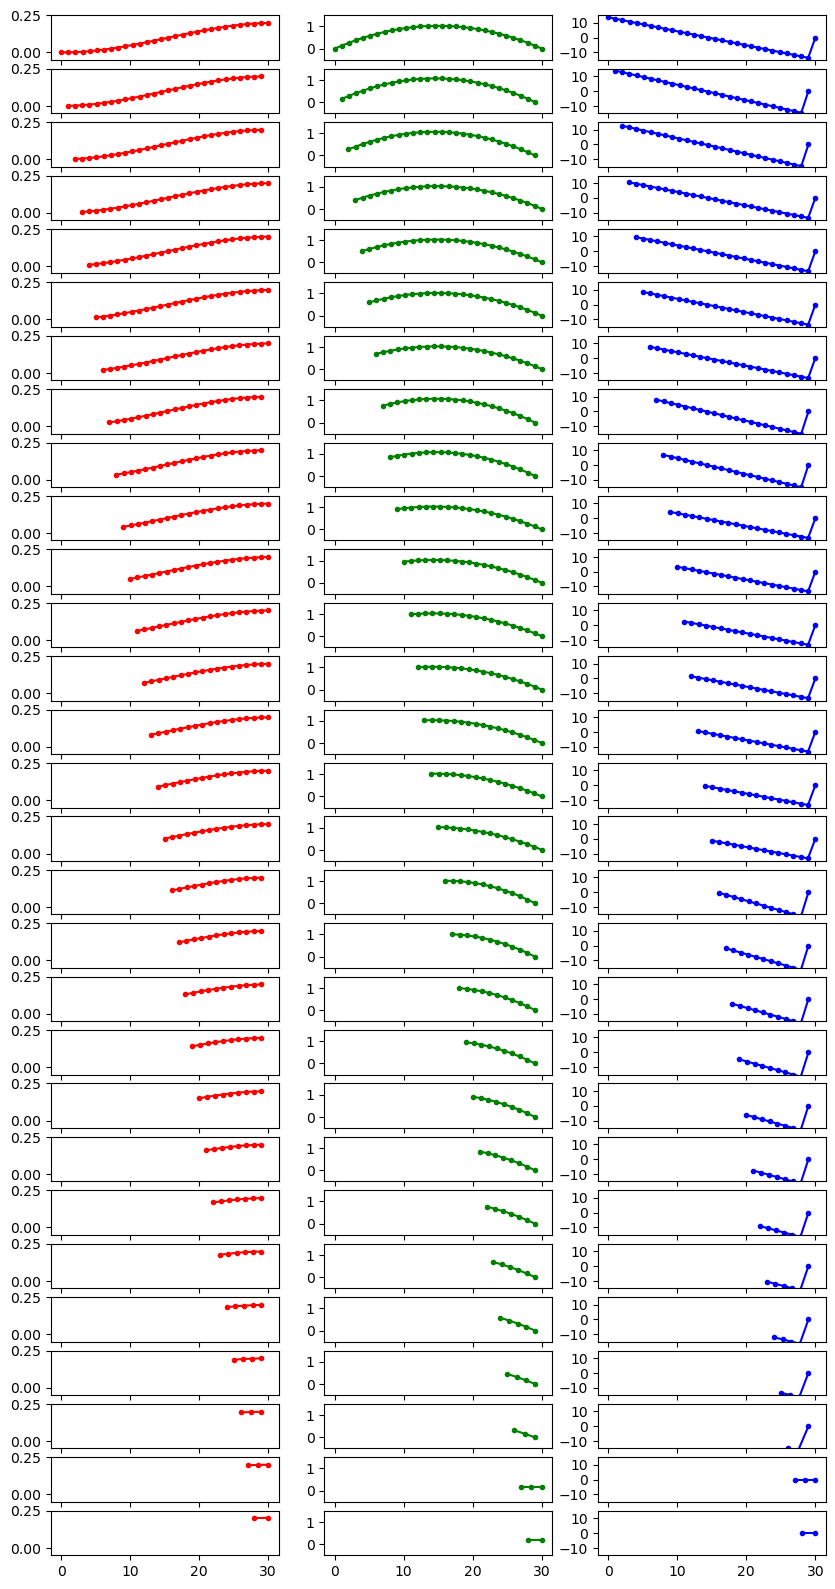

In [32]:
fig, axs = plt.subplots(len(df_list), 3, figsize=(10, 20), sharex=True)

for idx, df in enumerate(df_list):
    t = np.linspace(idx, len(df['Position_X']) + idx, len(df['Position_X']))

    axs[idx, 0].plot(t, df['Position_X'], '.-r', label='pos')
    axs[idx, 0].set_ylim([-0.05, 0.25])
    
    axs[idx, 1].plot(t, df['Velocity_X'], '.-g', label='pos')
    axs[idx, 1].set_ylim([-0.5, 1.5])

    axs[idx, 2].plot(t, df['Acceleration_X'], '.-b', label='pos')
    axs[idx, 2].set_ylim([-15, 15])

plt.show()

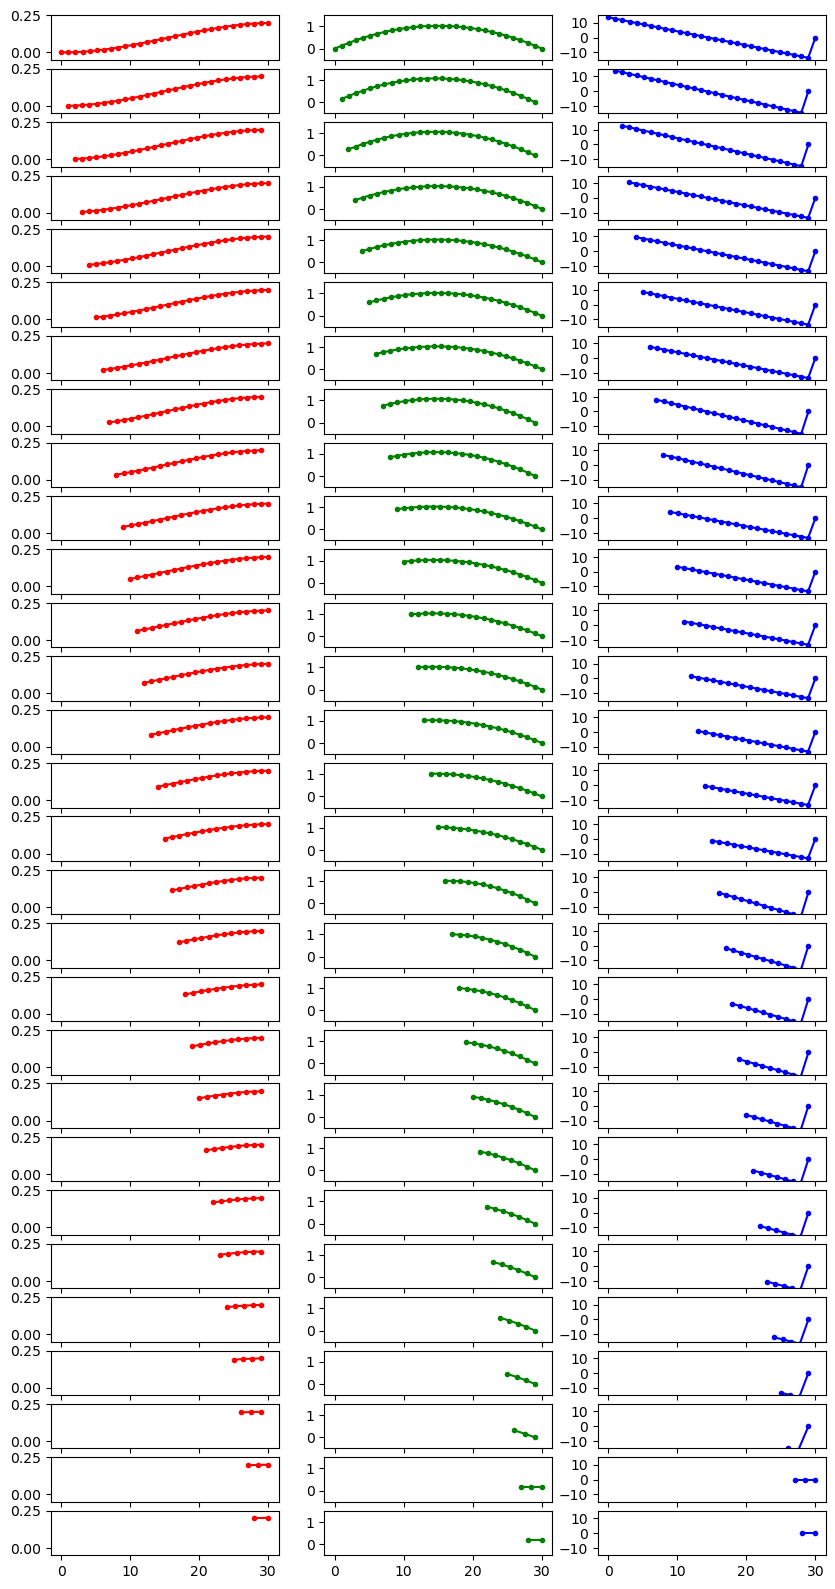

In [33]:
fig, axs = plt.subplots(len(df_list), 3, figsize=(10, 20), sharex=True)

for idx, df in enumerate(df_list):
    t = np.linspace(idx, len(df['Position_Y']) + idx, len(df['Position_Y']))

    axs[idx, 0].plot(t, df['Position_Y'], '.-r', label='pos')
    axs[idx, 0].set_ylim([-0.05, 0.25])
    
    axs[idx, 1].plot(t, df['Velocity_Y'], '.-g', label='pos')
    axs[idx, 1].set_ylim([-0.5, 1.5])

    axs[idx, 2].plot(t, df['Acceleration_Y'], '.-b', label='pos')
    axs[idx, 2].set_ylim([-15, 15])

plt.show()

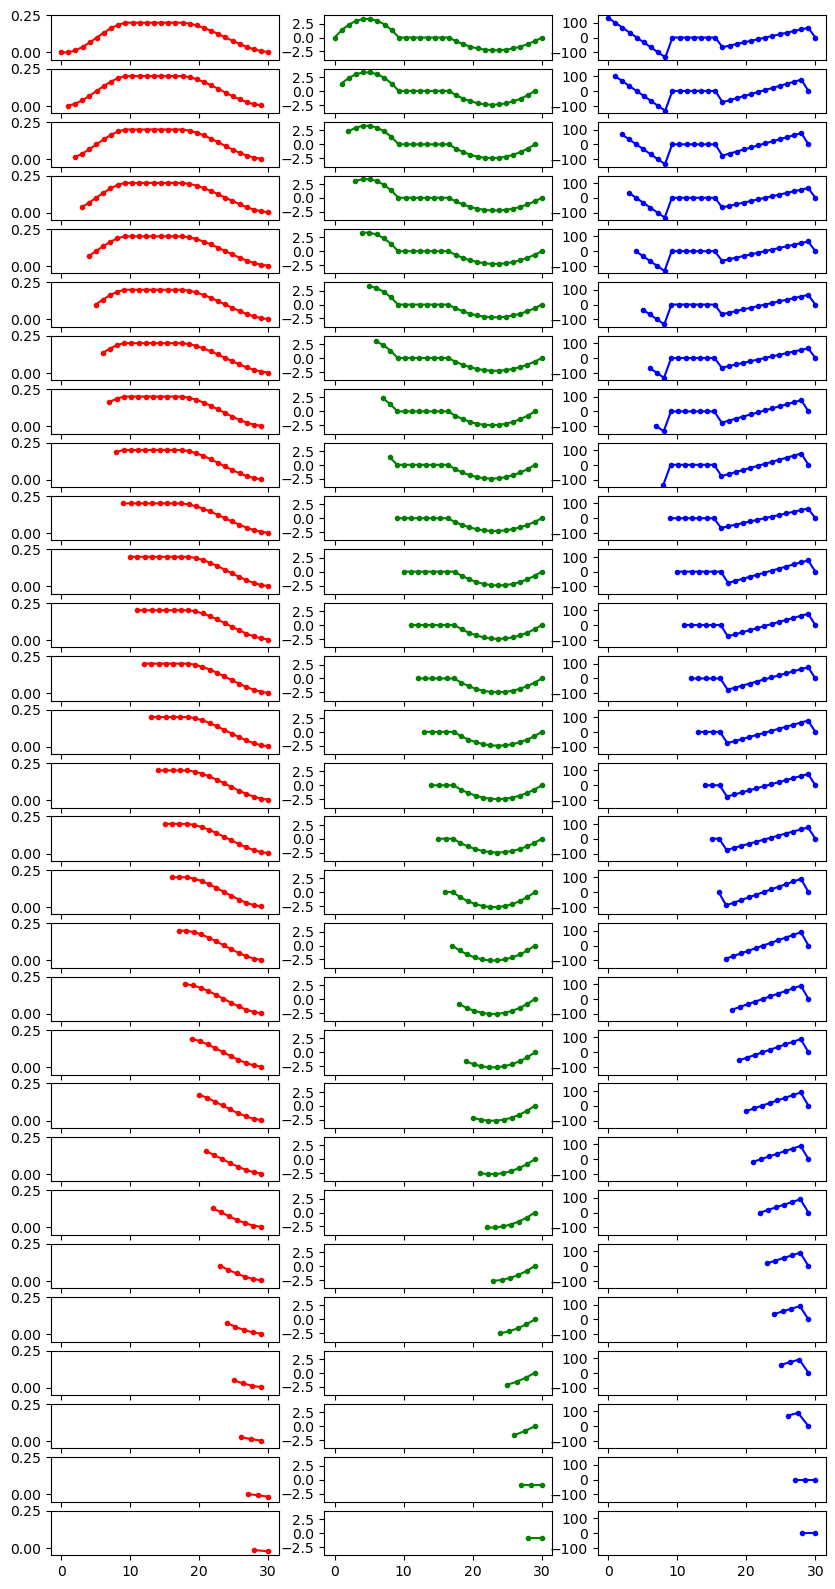

In [34]:
fig, axs = plt.subplots(len(df_list), 3, figsize=(10, 20), sharex=True)

for idx, df in enumerate(df_list):
    t = np.linspace(idx, len(df['Position_Z']) + idx, len(df['Position_Z']))

    axs[idx, 0].plot(t, df['Position_Z'], '.-r', label='pos')
    axs[idx, 0].set_ylim([-0.05, 0.25])
    
    axs[idx, 1].plot(t, df['Velocity_Z'], '.-g', label='pos')
    axs[idx, 1].set_ylim([-4, 4])

    axs[idx, 2].plot(t, df['Acceleration_Z'], '.-b', label='pos')
    axs[idx, 2].set_ylim([-150, 150])

plt.show()